In [1]:
%load_ext autoreload
%autoreload 2
from typing import Callable, List, Tuple
from utils import EarlyStopper, gpu2numpy
import torch.nn.init
from functools import lru_cache
import tqdm
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torch
import numpy as np
import sklearn.metrics as metrics
from sklearnex import patch_sklearn
patch_sklearn()
import math
from individual import Individual

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
torch.backends.cudnn.enable =True
torch.backends.cudnn.benchmark = True
from datasets import NParity
from utils import dataset2numpy, numpy2gpu
from sklearn.model_selection import train_test_split
N = 8
dataset = NParity(N) # XOR 问题
X, Y = dataset2numpy(dataset)
# X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2)
X_train, X_val, y_train, y_val = X, X, Y, Y
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
X_train, X_val, y_train, y_val = numpy2gpu(X_train, X_val, y_train, y_val, device=device)

In [37]:
indi = Individual(N, 1, 3, 3, connection_density=1)
indi = indi.to(device)
success, val_losses = indi.fit_bp(X_train, y_train, X_val, y_val, epochs=10000, 
                                  criterion=F.binary_cross_entropy, 
                                  optimizer=optim.AdamW(indi.parameters(), lr=0.1, 
                                                        weight_decay=0.001))
success

fit_bp: 100%|██████████| 10000/10000 [02:02<00:00, 81.46it/s, trian_loss=0.17, val_fitness=-.17] 


True

In [38]:
val_losses

array([-1.01931214, -0.8152889 , -0.78240538, ..., -0.17033766,
       -0.17033748, -0.17033729])

In [26]:
from losses import prechelt_mse_loss
indi2 = Individual(N, 1, 3, 3, connection_density=1)
indi2 = indi2.to(device)
success2, val_losses2 = indi2.fit_bp(X_train, y_train, X_val, y_val, epochs=10000, 
                                  criterion=prechelt_mse_loss, 
                                  optimizer=optim.Adam(indi2.parameters(), lr=0.1))
success2

fit_bp: 100%|██████████| 10000/10000 [02:21<00:00, 70.58it/s, trian_loss=4.49e-6, val_fitness=-4.49e-6]


True

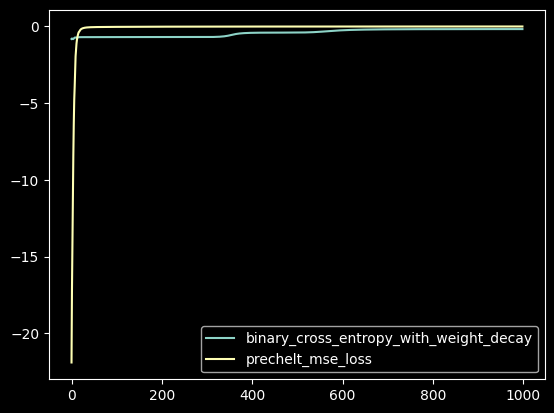

In [39]:
from matplotlib import pyplot as plt
start = 1
end = 1000
plt.plot(val_losses[start:end], label="binary_cross_entropy_with_weight_decay")
plt.plot(val_losses2[start:end], label="prechelt_mse_loss")
plt.legend()
plt.savefig("fig/loss_compare2.png")

In [40]:
indi.savefig("fig/loss_compare-binary_cross_entropy_with_weight_decay-8.dot")
# indi2.savefig("fig/loss_compare-prechelt_mse_loss-8.dot")

In [12]:
indi.real_connectivity()

tensor([[1, 1, 0, 0],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [0, 1, 1, 1],
        [1, 1, 0, 1],
        [0, 1, 1, 1],
        [1, 0, 1, 0],
        [1, 0, 1, 1],
        [0, 1, 1, 1],
        [0, 0, 1, 1],
        [0, 0, 0, 0],
        [0, 0, 0, 0]], device='cuda:0', dtype=torch.int8)

In [46]:
# indi.fitness_sklearn(X_train, y_train, metrics.accuracy_score, False)
indi2.fitness_sklearn(X_train, y_train, metrics.accuracy_score, False),\
indi2.fitness_torch(X_train, y_train, F.mse_loss),\
indi2.fitness_torch(X_train, y_train, prechelt_mse_loss)

(0.5, -0.5, -4.485188583203126e-06)

In [47]:
indi2(X_train).cpu().detach().numpy()

array([[8.97160604e-08],
       [4.48415065e-08],
       [2.18589236e-08],
       [1.09595799e-08],
       [8.20733135e-08],
       [4.33818705e-08],
       [2.43623788e-08],
       [1.26505402e-08],
       [2.23242616e-08],
       [9.30029742e-09],
       [5.33136868e-09],
       [2.30561481e-09],
       [1.96814476e-08],
       [9.18742415e-09],
       [5.42549872e-09],
       [2.50196242e-09],
       [2.62249049e-08],
       [1.35653977e-08],
       [6.35019282e-09],
       [3.29334982e-09],
       [2.71490297e-08],
       [1.47170409e-08],
       [7.56329577e-09],
       [3.98680866e-09],
       [4.76389195e-09],
       [2.30413333e-09],
       [1.21417898e-09],
       [6.00528183e-10],
       [5.18484367e-09],
       [2.65040279e-09],
       [1.37043932e-09],
       [6.87508994e-10],
       [3.58364431e-08],
       [1.85352640e-08],
       [9.28480759e-09],
       [4.87127672e-09],
       [4.08370688e-08],
       [2.17524097e-08],
       [1.10784715e-08],
       [5.78311843e-09],


In [45]:
list(indi.parameters())


[Parameter containing:
 tensor([[True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True],
         [True, True, True, True]], device='cuda:0'),
 Parameter containing:
 tensor([1, 1, 1, 1], device='cuda:0', dtype=torch.int8),
 Parameter containing:
 tensor([[ -5.2308,  -3.5667,  -8.6815,  -1.9350],
         [ -5.3182,  -3.5889,  -8.7049,  -1.9349],
         [ -5.2191,  -3.5637,  -8.6782,  -1.9350],
         [ -5.1425,  -3.5457,  -8.6591,  -1.9350],
         [  4.9935,   3.6616,   8.8903,   1.9396],
         [ -5.2334,  -3.5674,  -8.6822,  -1.9350],
         [  4.9909,   3.6590,   8.8869,   1.9396],
         [ -5.2312,  -3.5668,  -8.6816,  -1.9350],
         [  0.0624,  -6.46